# LANL Earthquake Prediction Challenge
https://www.kaggle.com/c/LANL-Earthquake-Prediction

## Data description

### File descriptions

    train.csv - A single, continuous training segment of experimental data.
    test - A folder containing many small segments of test data.
    sample_sumbission.csv - A sample submission file in the correct format.

### Data fields

    acoustic_data - the seismic signal [int16]
    time_to_failure - the time (in seconds) until the next laboratory earthquake [float64]
    seg_id - the test segment ids for which predictions should be made (one prediction per segment)
    
### Science

    https://doi.org/10.1002/2017GL074677
    https://doi.org/10.1002/2017GL076708
    https://rdcu.be/bdG8Y
    https://rdcu.be/bdG9r


### Library import

In [1]:
# Library import 
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from pandas import Series
from scipy import stats
from scipy.signal import hann
from datetime import datetime
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

/Users/manuelfreude/anaconda3/envs/tensorflow/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Unzipping the relevant files
# ONE-TIME EXERCISE ONLY
"""
from zipfile import ZipFile

os.makedirs('LANL-Earthquake-Prediction')
train_zf = ZipFile('LANL-Earthquake-Prediction.zip', 'r')
train_zf.extractall('LANL-Earthquake-Prediction')
train_zf.close()
totals_train = 0
for root, dirs, files in os.walk('LANL-Earthquake-Prediction'): 
    totals_train += len(files)
print('There are %d total files.' % totals_train)"""

"\nfrom zipfile import ZipFile\n\nos.makedirs('LANL-Earthquake-Prediction')\ntrain_zf = ZipFile('LANL-Earthquake-Prediction.zip', 'r')\ntrain_zf.extractall('LANL-Earthquake-Prediction')\ntrain_zf.close()\ntotals_train = 0\nfor root, dirs, files in os.walk('LANL-Earthquake-Prediction'): \n    totals_train += len(files)\nprint('There are %d total files.' % totals_train)"

In [3]:
# Unzipping the relevant files
# ONE-TIME EXERCISE ONLY
"""
os.makedirs('LANL-Earthquake-Prediction/test')
test_zf = ZipFile('LANL-Earthquake-Prediction/test.zip', 'r')
test_zf.extractall('LANL-Earthquake-Prediction/test')
test_zf.close()
totals_test = 0
for root, dirs, files in os.walk('LANL-Earthquake-Prediction/test'): 
    totals_test += len(files)
print('There are %d total files.' % totals_test)"""

"\nos.makedirs('LANL-Earthquake-Prediction/test')\ntest_zf = ZipFile('LANL-Earthquake-Prediction/test.zip', 'r')\ntest_zf.extractall('LANL-Earthquake-Prediction/test')\ntest_zf.close()\ntotals_test = 0\nfor root, dirs, files in os.walk('LANL-Earthquake-Prediction/test'): \n    totals_test += len(files)\nprint('There are %d total files.' % totals_test)"

### First look at the data

Source: https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

In [4]:
train_df = pd.read_csv('LANL-Earthquake-Prediction/train.csv', 
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

pd.options.display.precision = 15
train_df.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float32
dtypes: float32(1), int16(1)
memory usage: 3.5 GB


In [6]:
pd.options.display.precision = 15
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


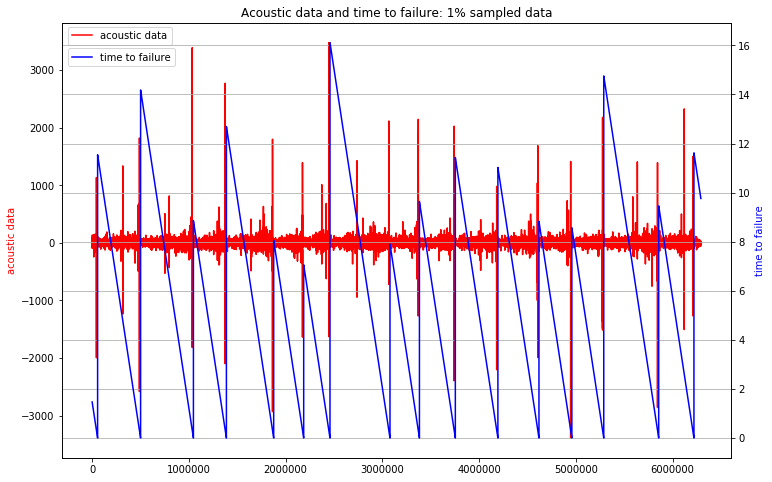

In [7]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

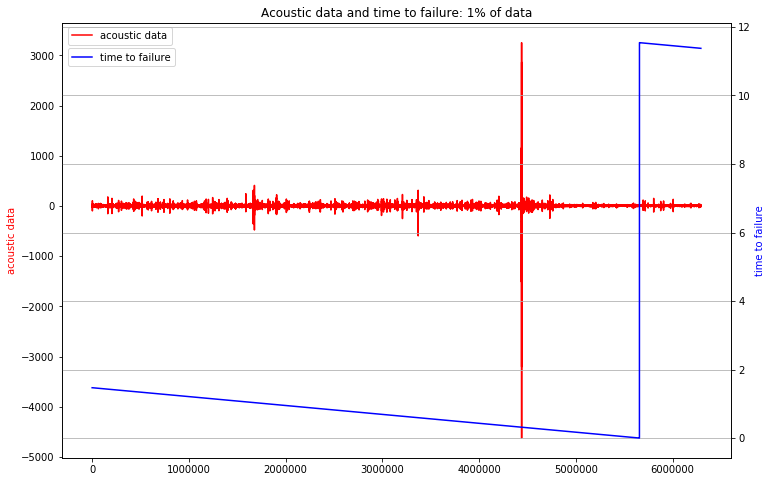

In [8]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

### Feature engineering

Source: https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

Further ideas along papers: 

- Kurtosis (https://en.wikipedia.org/wiki/Kurtosis)
- Autocorrelation (https://en.wikipedia.org/wiki/Autocorrelation)

In [9]:
# The test segments are 150,000 each.
# We split the train data in segments of the same dimmension with the test sets.
# We will create additional aggregation features, calculated on the segments.

rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [10]:
# Let's define some computation helper functions.

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [11]:
# Based on source with some additions

def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q10'] = np.quantile(xc, 0.10)
    X.loc[seg_id, 'q25'] = np.quantile(xc, 0.25)
    X.loc[seg_id, 'q50'] = np.quantile(xc, 0.40)
    X.loc[seg_id, 'q75'] = np.quantile(xc, 0.75)
    X.loc[seg_id, 'q90'] = np.quantile(xc, 0.90)
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q10'] = np.quantile(np.abs(xc), 0.10)
    X.loc[seg_id, 'abs_q25'] = np.quantile(np.abs(xc), 0.25)
    X.loc[seg_id, 'abs_q50'] = np.quantile(np.abs(xc), 0.50)
    X.loc[seg_id, 'abs_q75'] = np.quantile(np.abs(xc), 0.75)
    X.loc[seg_id, 'abs_q90'] = np.quantile(np.abs(xc), 0.90)
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q10_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.10)
        X.loc[seg_id, 'q25_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.25)
        X.loc[seg_id, 'q50_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.50)
        X.loc[seg_id, 'q75_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.75)
        X.loc[seg_id, 'q90_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.90)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q10_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.10)
        X.loc[seg_id, 'q25_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.25)
        X.loc[seg_id, 'q50_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.50)
        X.loc[seg_id, 'q75_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.75)
        X.loc[seg_id, 'q90_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.90)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

##### Train data processing

In [12]:
# Processing the train data

train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

In [13]:
# Iterate over all segments
# Takes about 45 min with local machine

for seg_id in range(segments):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

train_X.shape

(4194, 194)

In [14]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4194 entries, 0 to 4193
Columns: 194 entries, mean to abs_max_roll_mean_1000
dtypes: float64(194)
memory usage: 6.2 MB


In [15]:
# Scaling the data

scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

scaled_train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,q10_roll_mean_1000,q25_roll_mean_1000,q50_roll_mean_1000,q75_roll_mean_1000,q90_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140499795022,-0.170213582943171,-0.218193508692627,0.193218185209325,1.199316205489369,-0.105006593381723,1.424140499795018,0.156736086729651,-0.567194588224215,-0.169052005333305,...,0.965457528760674,1.355543630307086,1.484626392621775,1.576678338041653,1.615077095751950,1.509153430549683,0.885262121712506,-0.631300343511894,-1.832422175860377,-0.004741890462161
1,0.805716032556442,0.004734017014316,0.063936007992510,-0.018037271219829,0.078885810556771,-0.008598597346281,0.805716032556438,-0.222117948425051,-0.485093757384045,0.007211752080005,...,0.813989841781850,0.766512523290728,0.821627064439891,0.866676455933138,0.682085943199904,0.522427542165818,0.294356817530996,-0.912053970881953,-0.890022480697742,0.007341389309125
2,1.511155259373638,0.049252196732055,-0.086288799593083,0.163038834290874,0.078885810556770,0.043799511533280,1.511155259373636,-0.104253774698728,0.220973387841424,0.054839360725539,...,1.400927128824792,1.460174155895519,1.570426305680608,1.495202712225922,1.603699154867169,1.530919442793446,0.889790131706233,0.441127926802558,0.639209280695772,0.099555892826834
3,1.494934375107487,0.043949637951170,0.122560323147863,-0.187796120136112,0.078885810556771,0.044798043493984,1.494934375107485,-0.033850788412464,0.516536378866038,0.042216538302113,...,1.260819518369380,1.363294039609932,1.578226297776864,1.599957088274720,1.486127099057766,1.432972387696517,0.815077966809722,-0.949993650256284,-1.097513494373596,0.068075769212167
4,1.520242078970568,0.088495070341074,-0.067968701107035,0.087590456994748,1.199316205489368,0.078652301654897,1.520242078970566,-0.056323939067857,0.204553221673390,0.086841682459309,...,1.575114968850440,1.541553453575410,1.531426345199321,1.421486669821213,1.368555043248362,1.393068031916287,0.901110156690553,0.595415956258175,-0.465464227208672,0.138031599466982
5,1.538962489544185,-0.131053986788160,-0.078960760198664,0.019686917428235,1.519439175470111,-0.073279455182016,1.538962489544182,0.016520649604222,0.089612058497151,-0.134763478369498,...,1.294899747939614,1.378794858215624,1.547026329391834,1.700831672618006,1.706100622830199,1.741324227816475,1.193166801286013,-1.382505995123670,0.273910179965897,0.061716148279912
6,1.313015726042317,-0.101218785996422,-0.159569193537274,0.268666562505451,-0.721421614395085,-0.065897706573636,1.313015726042313,0.026620944137275,-0.304471929535669,-0.098334074796606,...,1.484234356663146,1.351668425655662,1.340326538841012,1.250775834778729,1.091691815052021,1.059322510845276,0.627165552070007,-0.031853409397449,0.021835030421887,-0.031134317331023
7,-0.054824008985421,-0.081617152532347,-0.089952819290292,0.057411106076298,-0.241237159423971,-0.099902265987057,-0.054824008985424,-0.027098806829572,0.262023803261509,-0.076354258709420,...,0.049078022538792,-0.039530044205341,-0.067572034533458,-0.060593761683994,-0.171259623158679,-0.213989205414785,-0.316924531622290,-0.514951993430610,0.114835774764259,-0.147515380391304
8,0.774732321036825,0.145943916470089,0.016303751928785,-0.025582108949441,-0.561360129404713,0.098087075492250,0.774732321036822,-0.342872656184990,-0.238791264863532,0.147895339130580,...,0.776122920037145,0.782013341896420,0.794327092102991,0.750282704767807,0.701049178007872,0.660278953042976,0.552453387173494,0.848347152087057,-0.227912239275442,0.023240441639764
9,0.825998647072221,0.040204715451199,-0.042320563226568,0.087590456994748,0.078885810556771,0.015541887002806,0.825998647072220,0.050997446880598,-0.008908938511054,0.046142156416401,...,0.643588693930674,0.716134862822224,0.880127005161824,0.952031873454381,0.845169762548433,0.747343002018023,0.380389007411829,1.943539230026109,-1.024070155238219,-0.070245986064396


##### Test data processing

In [16]:
submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

submission.shape, test_X.shape

((2624, 1), (2624, 194))

In [17]:
# Iterate over all segments
# Takes about XX min with local machine

for seg_id in test_X.index:
    seg = pd.read_csv('LANL-Earthquake-Prediction//test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)
    
test_X.shape

(2624, 194)

In [18]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2624 entries, seg_00030f to seg_ffe7cc
Columns: 194 entries, mean to abs_max_roll_mean_1000
dtypes: float64(194)
memory usage: 4.0+ MB


In [19]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

scaled_test_X.shape

(2624, 194)

In [20]:
scaled_test_X.tail(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,q10_roll_mean_1000,q25_roll_mean_1000,q50_roll_mean_1000,q75_roll_mean_1000,q90_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2614,-1.081634623438432,-0.268601942296902,-0.350098217792172,0.329025264342352,-0.081175674433601,-0.256057804503499,-1.081634623438434,0.296094951842351,-0.074589603183191,-0.265116961140863,...,-0.905168405427796,-1.054833662878272,-1.194670892442660,-1.177973772871168,-0.979093425978135,-0.834320554361995,-0.568229086274198,-0.621183095678739,-0.332742633283314,-0.197756385756125
2615,-0.734695164615844,-0.320940103312901,-0.390402434461477,0.400701222773672,0.559070265527885,-0.271490841421192,-0.734695164615847,0.457524666141680,0.368754883353731,-0.320648190853422,...,-0.670393490610618,-0.706065244250166,-0.714971378522829,-0.696879601387803,-0.728778726512949,-0.772650186338005,-0.620301201202069,0.066789756975814,0.379958267345616,-0.210475627620636
2616,-2.073321685925087,0.185999424044961,0.045615909506462,0.027231755157847,0.238947295547141,0.058192651768876,-2.073321685925090,-0.198272835507732,-0.304471929535669,0.182882262889467,...,-1.734453991636854,-1.915129095494270,-2.076069999319754,-2.221637741653632,-2.249630158112022,-2.114887608036642,-1.421758970091934,-0.681886582677671,-0.455029743769391,-0.255310955193040
2617,-0.427930383839279,-0.291596382506079,-0.196209390509370,0.310163170018320,0.238947295547143,-0.242327244436703,-0.427930383839283,0.412107554533329,0.171712889337321,-0.293675558394082,...,-0.121323125312385,-0.322419983759251,-0.488771607731363,-0.568846475105938,-0.565694907164423,-0.547734726485800,-0.409748736493715,0.491714165968333,0.259853681784336,-0.147833361437917
2618,-3.374741716678421,-0.152003490043633,-0.298801942031238,0.234714792722194,-0.721421614395085,-0.249113638779983,-3.374741716678424,0.271951919845560,0.007511227656980,-0.156716904848106,...,-3.196117170982501,-3.155194583949759,-3.327968730769078,-3.494209421061244,-3.383631599628534,-3.239464907297666,-2.157560594072741,-0.466895066223123,-0.517982573703920,-0.424476871991044
2619,-1.654729139621841,-0.172408272635962,-0.339106158700543,0.374294290720027,-1.041544584375828,-0.215590231150948,-1.654729139621846,0.224509483145720,0.532956545034073,-0.166937482945480,...,-1.647360071624031,-1.690367225711713,-1.643170437977465,-1.670707319471066,-1.574538998948345,-1.469162578138378,-0.817269635929239,0.643472883465663,-0.554972820552376,-0.240683827048852
2620,-1.487885758598570,-0.060792925011241,0.001647673139947,-0.221747889919369,0.238947295547142,-0.124402235161050,-1.487885758598571,0.230258375488919,-0.074589603183191,-0.063658336471214,...,-1.950295445581679,-1.500482197791965,-1.288270797597750,-1.251689815275878,-1.388699297830253,-1.425630553650856,-0.894245805822615,1.559083812366209,-0.820948539836463,-0.128754498641149
2621,-3.010670087956753,0.343254632011228,0.536594548932544,-0.580127682075968,-0.241237159423971,0.174257853534564,-3.010670087956756,-0.487617919728305,-1.043379407097206,0.340983182941972,...,-2.790941108314149,-2.942058328121473,-2.988669074581877,-3.013115249577878,-3.053671313969883,-2.956506748128763,-1.935688104380066,1.604611427615407,-0.954385032173800,-0.130344403874213
2622,-0.694312192710866,0.782096807867043,0.727123573187442,-0.640486383912869,-0.241237159423972,0.628381731544477,-0.694312192710869,-1.113687307556833,0.762838871386551,0.778366527088963,...,-0.662820106261678,-0.636311560524546,-0.675971418041539,-0.735677518442913,-0.800839018783229,-0.761767180216124,0.006828182929265,0.916638574960853,1.362109444329824,0.055356527347656
2623,-1.248764408517769,-0.349888468230894,-0.331778119306124,0.347887358666383,0.238947295547142,-0.306138783032271,-1.248764408517773,0.388179518203963,-0.230581181779515,-0.350400284361962,...,-1.030129247185325,-1.128462551255317,-1.253170833164593,-1.403001691790806,-1.

### Scoring

Submissions are evaluated using the mean absolute error between the predicted time remaining before the next lab earthquake and the act remaining time.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [21]:
from sklearn.metrics import mean_absolute_error

scores = pd.DataFrame(columns=['Regressor', 'MAE'])

### Run first model and feature importance along source

Source: https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

In [22]:
# We define the folds for cross-validation.

n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [23]:
# We define the model parameters.

params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [24]:
# LightGBM https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html

# We run the model. During training for each fold, we validate using the validation set 
# and also we predict using the current model for test set. The final result will be the 
# average over the all folds for the predictions done at each fold training.

oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
# Run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.90448	valid_1's l1: 2.23293
[2000]	training's l1: 1.47223	valid_1's l1: 2.10488
[3000]	training's l1: 1.22322	valid_1's l1: 2.08588
Early stopping, best iteration is:
[3096]	training's l1: 1.20321	valid_1's l1: 2.08527
fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.89438	valid_1's l1: 2.27362
[2000]	training's l1: 1.4743	valid_1's l1: 2.12232
[3000]	training's l1: 1.22817	valid_1's l1: 2.09481
[4000]	training's l1: 1.04001	valid_1's l1: 2.09026
Early stopping, best iteration is:
[3975]	training's l1: 1.04421	valid_1's l1: 2.09013
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.91067	valid_1's l1: 2.18376
[2000]	training's l1: 1.48249	valid_1's l1: 2.05283
[3000]	training's l1: 1.2307	valid_1's l1: 2.03232
Early stopping, best iteration is:
[3720]	training's l1: 1.09077	valid_1's l1: 2.02975


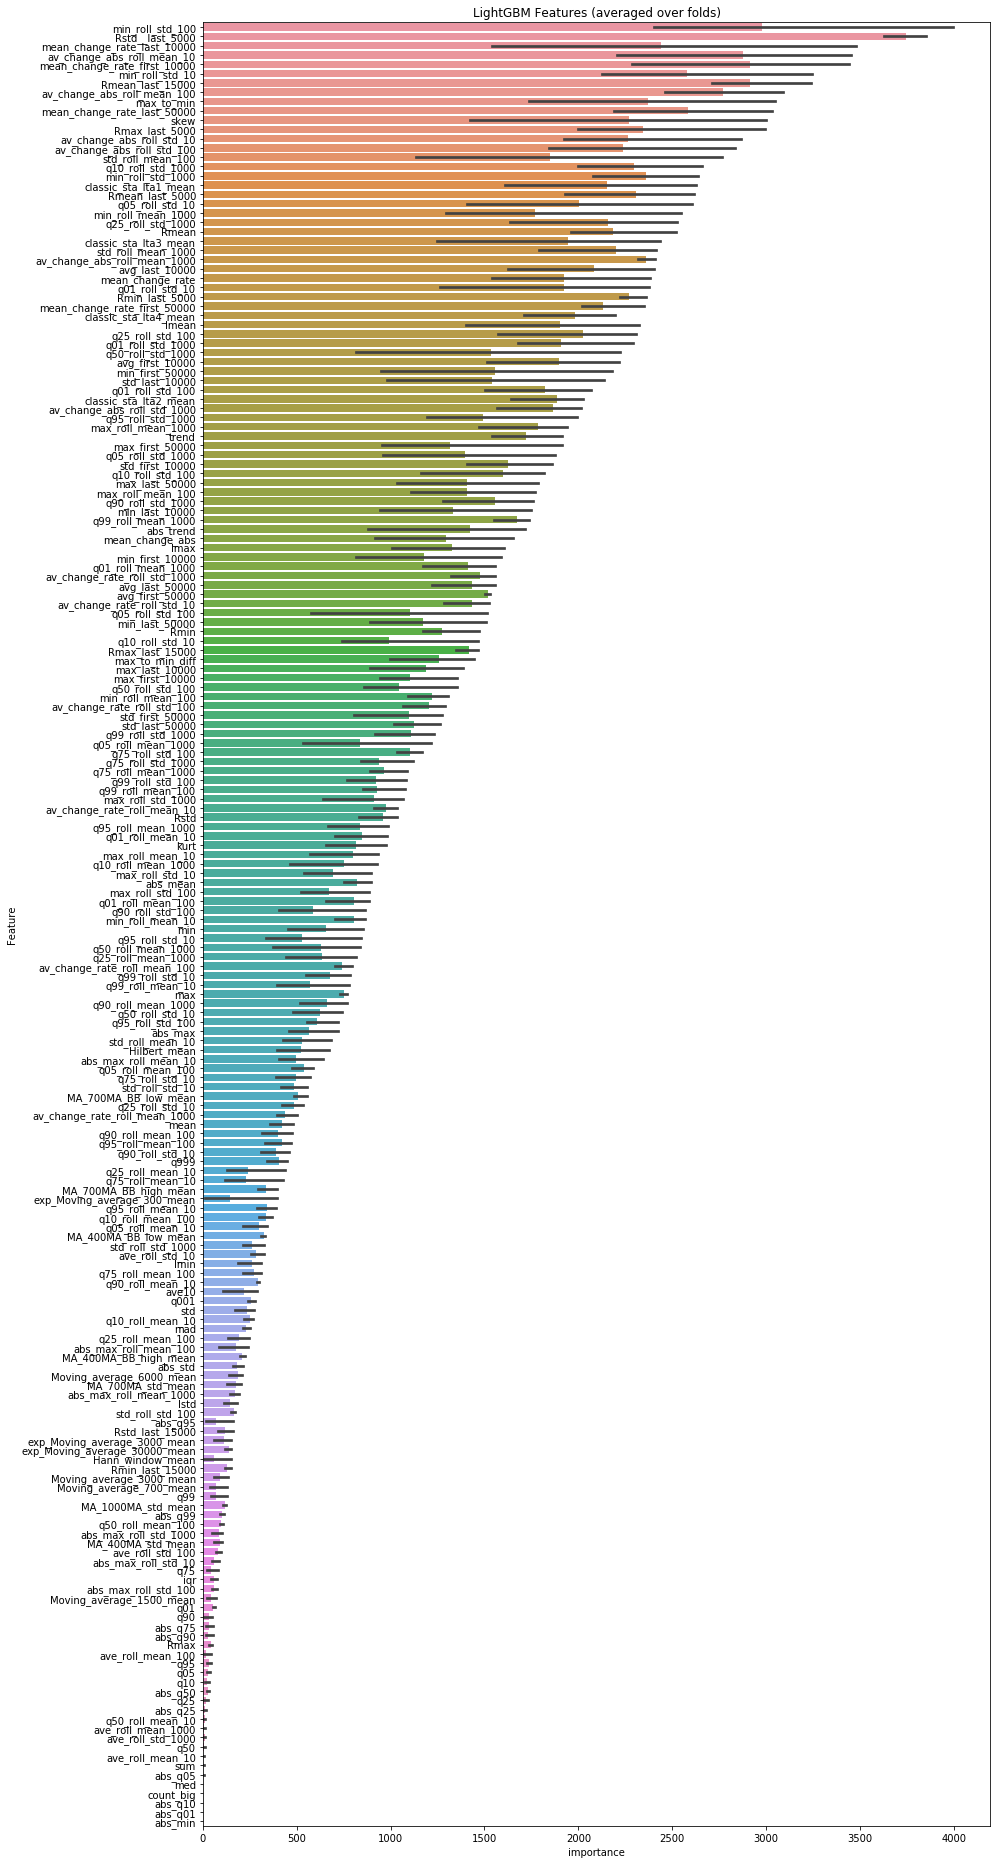

In [25]:
# Let's print features importance.

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

### Model selection and hyperparameter optimization

The following algorithms will be applied for the model selection: 

- LightGBM https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html
- SVR https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
- Linear SVR http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR
- ElasticNet http://scikit-learn.org/stable/modules/linear_model.html#elastic-net
- Lasso http://scikit-learn.org/stable/modules/linear_model.html#lasso
- SGD https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html
- Decision tree https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
- Random forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- Bagging https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
- Gradient boosting https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
- MLP http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
- AdaBoost http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
- XGBoost https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

In [26]:
# Train test split

from sklearn.cross_validation import train_test_split

# Train size: 0.6 3rd best, 0.7 1st best, 0.8 2nd best, 0.9 much off

train_variables, valid_variables, train_targets, valid_targets = train_test_split(scaled_train_X, train_y, train_size=.7, random_state=25)

print('Observations: %d' % (len(train_X)))
print('Training Observations: %d' % (len(train_variables)))
print('Validation Observations: %d' % (len(valid_variables)))

Observations: 4194
Training Observations: 2935
Validation Observations: 1259


#### Scoring

Submissions are evaluated using the mean absolute error between the predicted time remaining before the next lab earthquake and the act remaining time.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [27]:
from sklearn.metrics import mean_absolute_error

scores = pd.DataFrame(columns=['Regressor', 'MAE'])

In [28]:
# Defining number of cross-validations

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

##### LightGBM

In [29]:
# https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html

oof = np.zeros(len(scaled_train_X))
feature_importance_df = pd.DataFrame()

# Run model

for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
# Scoring

regressor = 'LightGBM'

MAE = mean_absolute_error(train_y, oof)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.94558	valid_1's l1: 2.26687
[2000]	training's l1: 1.55066	valid_1's l1: 2.13144
[3000]	training's l1: 1.3205	valid_1's l1: 2.1065
[4000]	training's l1: 1.14571	valid_1's l1: 2.10352
Early stopping, best iteration is:
[3856]	training's l1: 1.1689	valid_1's l1: 2.10334
fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.9339	valid_1's l1: 2.26336
[2000]	training's l1: 1.54103	valid_1's l1: 2.13972
[3000]	training's l1: 1.31667	valid_1's l1: 2.11589
[4000]	training's l1: 1.14356	valid_1's l1: 2.11207
Early stopping, best iteration is:
[4402]	training's l1: 1.08337	valid_1's l1: 2.11121
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.94603	valid_1's l1: 2.26058
[2000]	training's l1: 1.55936	valid_1's l1: 2.09885
[3000]	training's l1: 1.33117	valid_1's l1: 2.0667
[4000]	training's l1: 1.1555	valid_1's l1: 2.0588

##### SVR

In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

from sklearn.svm import SVR

SVR = SVR()

SVR.fit(train_variables, train_targets)

SVR_preds = SVR.predict(valid_variables)

regressor = 'SVR'

MAE = mean_absolute_error(valid_targets, SVR_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


##### LinearSVR

In [31]:
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR

from sklearn.svm import LinearSVR

LinSVR = LinearSVR()

LinSVR.fit(train_variables, train_targets)

LinSVR_preds = LinSVR.predict(valid_variables)

regressor = 'LinSVR'

MAE = mean_absolute_error(valid_targets, LinSVR_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.14


##### ElasticNet

In [32]:
# http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

from sklearn.linear_model import ElasticNet

Elastic = ElasticNet(random_state=25)

Elastic.fit(train_variables, train_targets)

Elastic_preds = Elastic.predict(valid_variables)

regressor = 'Elastic'

MAE = mean_absolute_error(valid_targets, Elastic_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.28


##### Lasso

In [33]:
# http://scikit-learn.org/stable/modules/linear_model.html#lasso

from sklearn import linear_model

Lasso = linear_model.Lasso(random_state=25)

Lasso.fit(train_variables, train_targets)

Lasso_preds = Lasso.predict(valid_variables)

regressor = 'Lasso'

MAE = mean_absolute_error(valid_targets, Lasso_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.37


##### Decision Tree

In [34]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

from sklearn.tree import DecisionTreeRegressor

DecTree = DecisionTreeRegressor(random_state=25)

DecTree.fit(train_variables, train_targets)

DecTree_preds = DecTree.predict(valid_variables)

regressor = 'DecTree'

MAE = mean_absolute_error(valid_targets, DecTree_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.95


##### Random Forest (top-performing in their first paper)

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

from sklearn.ensemble import RandomForestRegressor

RndmForest = RandomForestRegressor(random_state=25)

RndmForest.fit(train_variables, train_targets)

RndmForest_preds = RndmForest.predict(valid_variables)

regressor = 'RndmForest'

MAE = mean_absolute_error(valid_targets, RndmForest_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.13


##### Bagging

In [36]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

from sklearn.ensemble import BaggingRegressor

base_estimator = RandomForestRegressor(random_state=25)

Bagging = BaggingRegressor(base_estimator=base_estimator, random_state=25)

Bagging.fit(train_variables, train_targets)

Bagging_preds = Bagging.predict(valid_variables)

regressor = 'Bagging'

MAE = mean_absolute_error(valid_targets, Bagging_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.06


##### Gradient Boosting

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.06


##### AdaBoost

In [38]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

from sklearn.ensemble import AdaBoostRegressor

base_estimator = RandomForestRegressor(random_state=25)

AdaBoost = AdaBoostRegressor(base_estimator=base_estimator, random_state=25)

AdaBoost.fit(train_variables, train_targets)

AdaBoost_preds = AdaBoost.predict(valid_variables)

regressor = 'AdaBoost'

MAE = mean_absolute_error(valid_targets, AdaBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.09


##### XGBoost (top-performing in their second paper)

In [39]:
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

from xgboost import XGBRegressor

XGBoost = XGBRegressor(random_state=25)

XGBoost.fit(train_variables, train_targets)

XGBoost_preds = XGBoost.predict(valid_variables)

regressor = 'XGBoost'

MAE = mean_absolute_error(valid_targets, XGBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


#### Performance comparison basic models

In [40]:
# Looking at performance scores

pd.options.display.max_colwidth = 200

scores

,Regressor,MAE
0,LightGBM,2.074296161912692
1,SVR,2.046054044218325
2,LinSVR,2.141308130470632
3,Elastic,2.279288416970476
4,Lasso,2.373345046765726
5,DecTree,2.947543543994625
6,RndmForest,2.133414621897705
7,Bagging,2.058486877265501
8,GradBoost,2.055248444688900
9,AdaBoost,2.093689973025512


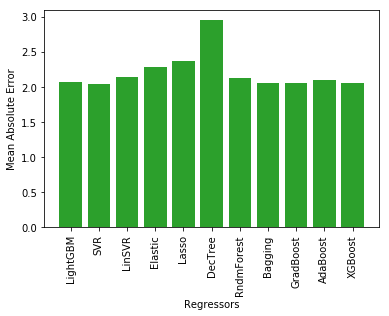

In [41]:
# Plotting MAE curve area comparison

plt.bar(scores['Regressor'], scores['MAE'], color='C2')
plt.xticks(rotation=90)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Regressors');

##### Grid search LGBM

In [59]:
# Use grid search for https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html
# Params useful for grid search in LGB: num_leaves, max_depth, n_estimators and learning rate

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

start_time = datetime.now() 

train_data = lgb.Dataset(train_variables, label=train_targets)

lgb_simple = lgb.LGBMRegressor(boosting_type='gbdt')

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

num_leaves = [10, 20, 30, 40, 50]

max_depth = [1, 2, 5, 7, 10]

n_estimators = [25, 50, 100, 200]

learning_rate = [0.001, 0.01, 0.1]

param_grid = dict(num_leaves= num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

grid_search = GridSearchCV(lgb_simple, param_grid, scoring=mae_scorer, n_jobs=-1, cv=5, return_train_score=True)
grid_result = grid_search.fit(train_variables, train_targets)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Best: 3.007486 using {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 25, 'num_leaves': 10}
3.007486 (0.085463) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 25, 'num_leaves': 10}
3.007486 (0.085463) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 25, 'num_leaves': 20}
3.007486 (0.085463) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 25, 'num_leaves': 30}
3.007486 (0.085463) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 25, 'num_leaves': 40}
3.007486 (0.085463) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 25, 'num_leaves': 50}
2.977395 (0.084968) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 50, 'num_leaves': 10}
2.977395 (0.084968) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 50, 'num_leaves': 20}
2.977395 (0.084968) with: {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 50, 'num_leaves': 30}
2.977395 (0.084968) with: {'learning_rate': 0.001, 'max_dept

##### Grid search Random Forest

In [119]:
# Using grid search for https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# Params useful for grid search in random forest: n_estimators, criterion

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

start_time = datetime.now() 

RndmForest_simple = RandomForestRegressor()

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

n_estimators = [25, 50, 100, 250, 500]

criterion = ['mse', 'mae']

param_grid = dict(n_estimators=n_estimators, criterion=criterion)

grid_search = GridSearchCV(RndmForest_simple, param_grid, scoring=mae_scorer, n_jobs=-1, cv=5, return_train_score=True)
grid_result = grid_search.fit(train_variables, train_targets)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Plot
results = np.array(means).reshape(len(criterion), len(n_estimators))
for i, value in enumerate(criterion):
    plt.plot(n_estimates, results[i], label='Criterion: ' + str(value))
plt.legend()
plt.title("RndmForest n_estimators / criterion / MAE")
plt.xlabel('n_estimators')
plt.ylabel("Mean Absolute Error")
plt.savefig('Earthquake_rforest_grid.png')

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Best: -2.096747 using {'criterion': 'mse', 'n_estimators': 500}
-2.126929 (0.028756) with: {'criterion': 'mse', 'n_estimators': 25}
-2.116978 (0.037893) with: {'criterion': 'mse', 'n_estimators': 50}
-2.103385 (0.037614) with: {'criterion': 'mse', 'n_estimators': 100}
-2.103086 (0.029806) with: {'criterion': 'mse', 'n_estimators': 250}
-2.096747 (0.039855) with: {'criterion': 'mse', 'n_estimators': 500}
-2.133949 (0.027706) with: {'criterion': 'mae', 'n_estimators': 25}
-2.124240 (0.032810) with: {'criterion': 'mae', 'n_estimators': 50}
-2.126735 (0.034393) with: {'criterion': 'mae', 'n_estimators': 100}
-2.109362 (0.034916) with: {'criterion': 'mae', 'n_estimators': 250}
-2.107988 (0.032639) with: {'criterion': 'mae', 'n_estimators': 500}


NameError: name 'n_estimates' is not defined

Time elapsed (hh:mm:ss.ms) 1:46:21.309054


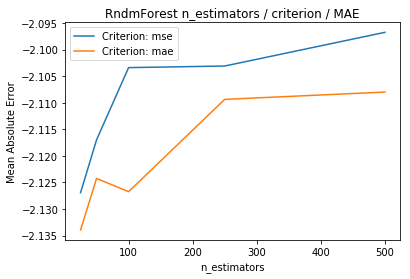

In [120]:
# Plot
results = np.array(means).reshape(len(criterion), len(n_estimators))
for i, value in enumerate(criterion):
    plt.plot(n_estimators, results[i], label='Criterion: ' + str(value))
plt.legend()
plt.title("RndmForest n_estimators / criterion / MAE")
plt.xlabel('n_estimators')
plt.ylabel("Mean Absolute Error")
plt.savefig('Earthquake_rforest_grid.png')

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

##### Grid search Bagging

Best: -2.099723 using {'n_estimators': 250}
-2.133212 (0.066879) with: {'n_estimators': 25}
-2.122850 (0.049349) with: {'n_estimators': 50}
-2.103075 (0.042039) with: {'n_estimators': 100}
-2.099723 (0.045947) with: {'n_estimators': 250}
Time elapsed (hh:mm:ss.ms) 0:03:25.175046


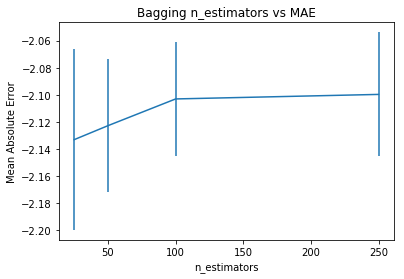

In [66]:
# Using grid search for https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
# Params useful for grid search in bagging: n_estimators

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

start_time = datetime.now()

Bagging_simple = BaggingRegressor()

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

n_estimators = [25, 50, 100, 250]

param_grid = dict(n_estimators=n_estimators)

grid_search = GridSearchCV(Bagging_simple, param_grid, scoring=mae_scorer, n_jobs=-1, cv=5, return_train_score=True)
grid_result = grid_search.fit(train_variables, train_targets)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("Bagging n_estimators vs MAE")
plt.xlabel('n_estimators')
plt.ylabel("Mean Absolute Error")
plt.savefig('Earthquake_bagging_grid.png')

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

##### Grid search Gradient Boosting

Best: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}
-3.000246 (0.086359) with: {'learning_rate': 0.001, 'n_estimators': 25}
-2.962913 (0.086561) with: {'learning_rate': 0.001, 'n_estimators': 50}
-2.891856 (0.086781) with: {'learning_rate': 0.001, 'n_estimators': 100}
-2.708398 (0.087124) with: {'learning_rate': 0.001, 'n_estimators': 250}
-2.707170 (0.087274) with: {'learning_rate': 0.01, 'n_estimators': 25}
-2.486532 (0.088170) with: {'learning_rate': 0.01, 'n_estimators': 50}
-2.254908 (0.070022) with: {'learning_rate': 0.01, 'n_estimators': 100}
-2.114707 (0.033966) with: {'learning_rate': 0.01, 'n_estimators': 250}
-2.109414 (0.036071) with: {'learning_rate': 0.1, 'n_estimators': 25}
-2.099464 (0.035319) with: {'learning_rate': 0.1, 'n_estimators': 50}
-2.125033 (0.037821) with: {'learning_rate': 0.1, 'n_estimators': 100}
-2.153037 (0.044392) with: {'learning_rate': 0.1, 'n_estimators': 250}
Time elapsed (hh:mm:ss.ms) 0:01:01.786869


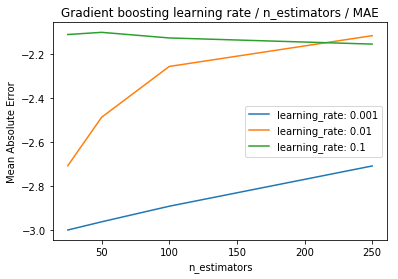

In [68]:
# Using grid search for https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Params useful for grid search in gradient boosting: n_estimators and learning rate

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

start_time = datetime.now()

GradBoost_simple = GradientBoostingRegressor()

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

n_estimators = [25, 50, 100, 250]

learning_rate = [0.001, 0.01, 0.1]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

grid_search = GridSearchCV(GradBoost_simple, param_grid, scoring=mae_scorer, n_jobs=-1, cv=5, return_train_score=True)
grid_result = grid_search.fit(train_variables, train_targets)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Plot results
results = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, results[i], label='Learning rate: ' + str(value))
plt.legend()
plt.title("Gradient boosting learning rate / n_estimators / MAE")
plt.xlabel('n_estimators')
plt.ylabel("Mean Absolute Error")
plt.savefig('Earthquake_gradboost_grid.png')

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

##### Grid search AdaBoost

Best: -2.102515 using {'learning_rate': 0.01, 'n_estimators': 50}
-2.117021 (0.055356) with: {'learning_rate': 0.001, 'n_estimators': 25}
-2.107210 (0.051038) with: {'learning_rate': 0.001, 'n_estimators': 50}
-2.106537 (0.057307) with: {'learning_rate': 0.001, 'n_estimators': 100}
-2.105409 (0.051133) with: {'learning_rate': 0.001, 'n_estimators': 250}
-2.105684 (0.054196) with: {'learning_rate': 0.01, 'n_estimators': 25}
-2.102515 (0.042745) with: {'learning_rate': 0.01, 'n_estimators': 50}
-2.108077 (0.052218) with: {'learning_rate': 0.01, 'n_estimators': 100}
-2.118039 (0.044381) with: {'learning_rate': 0.01, 'n_estimators': 250}
-2.119845 (0.046299) with: {'learning_rate': 0.1, 'n_estimators': 25}
-2.137768 (0.041249) with: {'learning_rate': 0.1, 'n_estimators': 50}
-2.168843 (0.055070) with: {'learning_rate': 0.1, 'n_estimators': 100}
-2.315236 (0.101530) with: {'learning_rate': 0.1, 'n_estimators': 250}
Time elapsed (hh:mm:ss.ms) 0:02:23.910861


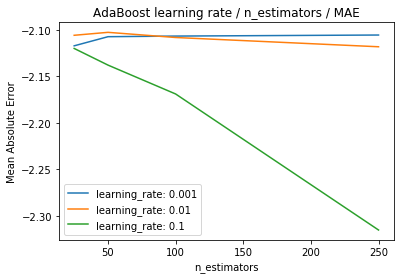

In [69]:
# Use grid search http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
# Params useful for grid search in adaboost: learning rate and n_estimators

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

start_time = datetime.now()

AdaBoost_simple = AdaBoostRegressor()

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

n_estimators = [25, 50, 100, 250]

learning_rate = [0.001, 0.01, 0.1]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

grid_search = GridSearchCV(AdaBoost_simple, param_grid, scoring=mae_scorer, n_jobs=-1, cv=5, return_train_score=True)
grid_result = grid_search.fit(train_variables, train_targets)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Plot results
results = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, results[i], label='Learning rate: ' + str(value))
plt.legend()
plt.title("AdaBoost learning rate / n_estimators / MAE")
plt.xlabel('n_estimators')
plt.ylabel("Mean Absolute Error")
plt.savefig('Earthquake_adaboost_gridsearch.png')

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

##### Grid search XGBoost

Best: -2.103335 using {'learning_rate': 0.1, 'max_depth': 1}
-4.734449 (0.151479) with: {'learning_rate': 0.001, 'max_depth': 1}
-4.748664 (0.150347) with: {'learning_rate': 0.001, 'max_depth': 10}
-4.769540 (0.151130) with: {'learning_rate': 0.001, 'max_depth': 20}
-2.643893 (0.070845) with: {'learning_rate': 0.01, 'max_depth': 1}
-2.621711 (0.057737) with: {'learning_rate': 0.01, 'max_depth': 10}
-2.716350 (0.066042) with: {'learning_rate': 0.01, 'max_depth': 20}
-2.103335 (0.038150) with: {'learning_rate': 0.1, 'max_depth': 1}
-2.164977 (0.034764) with: {'learning_rate': 0.1, 'max_depth': 10}
-2.207600 (0.053834) with: {'learning_rate': 0.1, 'max_depth': 20}
Time elapsed (hh:mm:ss.ms) 0:01:40.370038


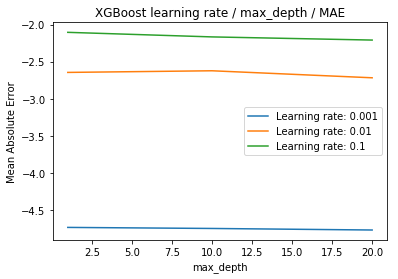

In [74]:
# Using grid search for https://xgboost.readthedocs.io/en/latest/parameter.html
# Params useful for grid search in XGBoost: eta (learning rate), max_depth, alpha L1 regularization, tree_method

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

start_time = datetime.now()

XGBoost_simple = XGBRegressor()

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

eta = [0.001, 0.01, 0.1]

max_depth = [1, 10, 20]

alpha = [0, 0.33, 0.66]

tree_method = ['approx', 'hist']

#param_grid = dict(learning_rate=eta, max_depth=max_depth, alpha=alpha, tree_method=tree_method)
param_grid = dict(learning_rate=eta, max_depth=max_depth)

grid_search = GridSearchCV(XGBoost_simple, param_grid, scoring=mae_scorer, n_jobs=-1, cv=5, return_train_score=True)
grid_result = grid_search.fit(train_variables, train_targets)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Plot results
results = np.array(means).reshape(len(eta), len(max_depth))
for i, value in enumerate(eta):
    plt.plot(max_depth, results[i], label='Learning rate: ' + str(value))
plt.legend()
plt.title("XGBoost learning rate / max_depth / MAE")
plt.xlabel('max_depth')
plt.ylabel("Mean Absolute Error")
plt.savefig('Earthquake_xgboost_gridsearch.png')    

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

##### Fine-tuned LGBM

In [99]:
# https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html
# Grid search results: 2.096217 (0.039276) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200, 'num_leaves': 10}

train_data = lgb.Dataset(train_variables, label=train_targets)

lgb_tuned = lgb.LGBMRegressor(boosting_type='gbdt', 
                              learning_rate=0.1, 
                              max_depth=1, 
                              n_estimators=200, 
                              num_leaves=10)

lgb_tuned.fit(train_variables, train_targets)

lgb_preds = lgb_tuned.predict(valid_variables)

regressor = 'LGBM (along grid search)'

MAE = mean_absolute_error(valid_targets, lgb_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.06


##### Fine-tuned Random Forest

In [100]:
# Random Forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# Grid search results: -2.096747 using {'criterion': 'mse', 'n_estimators': 500}
# Try bootstrap=True and bootstrap=False
# Try max_depth=1, max_depth=10, max_depth=20

RndmForest = RandomForestRegressor(criterion='mse', 
                                   n_estimators=500, 
                                   bootstrap=True,
                                   max_depth=None,
                                   random_state=25)

RndmForest.fit(train_variables, train_targets)

RndmForest_preds = RndmForest.predict(valid_variables)

regressor = 'RndmForest (mse, n_estimators=500, bootstrap=True, max_depth=None)'

MAE = mean_absolute_error(valid_targets, RndmForest_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.06


In [101]:
# Random Forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# Grid search results: -2.096747 using {'criterion': 'mse', 'n_estimators': 500}
# Try bootstrap=True and bootstrap=False
# Try max_depth=1, max_depth=10, max_depth=20

RndmForest = RandomForestRegressor(criterion='mse', 
                                   n_estimators=500, 
                                   bootstrap=False,
                                   max_depth=None,
                                   random_state=25)

RndmForest.fit(train_variables, train_targets)

RndmForest_preds = RndmForest.predict(valid_variables)

regressor = 'RndmForest (mse, n_estimators=500, bootstrap=False, max_depth=None)'

MAE = mean_absolute_error(valid_targets, RndmForest_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.79


In [102]:
# Random Forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# Grid search results: -2.096747 using {'criterion': 'mse', 'n_estimators': 500}
# Try bootstrap=True and bootstrap=False
# Try max_depth=1, max_depth=10, max_depth=20

from sklearn.ensemble import RandomForestRegressor

RndmForest = RandomForestRegressor(criterion='mse', 
                                   n_estimators=500, 
                                   bootstrap=True, 
                                   max_depth=1, 
                                   random_state=25)

RndmForest.fit(train_variables, train_targets)

RndmForest_preds = RndmForest.predict(valid_variables)

regressor = 'RndmForest (mse, n_estimators=500, bootstrap=True, max_depth=1)'

MAE = mean_absolute_error(valid_targets, RndmForest_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.19


In [103]:
# Random Forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# Grid search results: -2.096747 using {'criterion': 'mse', 'n_estimators': 500}
# Try bootstrap=True and bootstrap=False
# Try max_depth=1, max_depth=10, max_depth=20

from sklearn.ensemble import RandomForestRegressor

RndmForest = RandomForestRegressor(criterion='mse', 
                                   n_estimators=500, 
                                   bootstrap=True, 
                                   max_depth=7, 
                                   random_state=25)

RndmForest.fit(train_variables, train_targets)

RndmForest_preds = RndmForest.predict(valid_variables)

regressor = 'RndmForest (mse, n_estimators=500, bootstrap=True, max_depth=7)'

MAE = mean_absolute_error(valid_targets, RndmForest_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


In [104]:
# Random Forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# Grid search results: -2.096747 using {'criterion': 'mse', 'n_estimators': 500}
# Try bootstrap=True and bootstrap=False
# Try max_depth=1, max_depth=10, max_depth=20

RndmForest = RandomForestRegressor(criterion='mse', 
                                   n_estimators=500, 
                                   bootstrap=True, 
                                   max_depth=10, 
                                   random_state=25)

RndmForest.fit(train_variables, train_targets)

RndmForest_preds = RndmForest.predict(valid_variables)

regressor = 'RndmForest (mse, n_estimators=500, bootstrap=True, max_depth=10)'

MAE = mean_absolute_error(valid_targets, RndmForest_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


In [105]:
# Random Forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# Grid search results: -2.096747 using {'criterion': 'mse', 'n_estimators': 500}
# Try bootstrap=True and bootstrap=False
# Try max_depth=1, max_depth=10, max_depth=20

from sklearn.ensemble import RandomForestRegressor

RndmForest = RandomForestRegressor(criterion='mse', 
                                   n_estimators=500, 
                                   bootstrap=True, 
                                   max_depth=15, 
                                   random_state=25)

RndmForest.fit(train_variables, train_targets)

RndmForest_preds = RndmForest.predict(valid_variables)

regressor = 'RndmForest (mse, n_estimators=500, bootstrap=True, max_depth=15)'

MAE = mean_absolute_error(valid_targets, RndmForest_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.06


In [106]:
# Random Forest https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# Grid search results: -2.096747 using {'criterion': 'mse', 'n_estimators': 500}
# Try bootstrap=True and bootstrap=False
# Try max_depth=1, max_depth=10, max_depth=20

RndmForest = RandomForestRegressor(criterion='mse', 
                                   n_estimators=500, 
                                   bootstrap=True, 
                                   max_depth=20, 
                                   random_state=25)

RndmForest.fit(train_variables, train_targets)

RndmForest_preds = RndmForest.predict(valid_variables)

regressor = 'RndmForest (mse, n_estimators=500, bootstrap=True, max_depth=20)'

MAE = mean_absolute_error(valid_targets, RndmForest_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.06


##### Fine-tuned Gradient Boosting

In [107]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='ls',
                                      learning_rate=0.1,
                                      n_estimators=50,
                                      criterion='friedman_mse',
                                      max_depth=3,
                                      #alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss ls, learning_rate=0.1, n_estimators=50, criterion=friedman_mse, max_depth=3)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


In [108]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='ls',
                                      learning_rate=0.1,
                                      n_estimators=50,
                                      criterion='mae',
                                      max_depth=3,
                                      #alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss ls, learning_rate=0.1, n_estimators=50, criterion=mae, max_depth=3)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


In [109]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='ls',
                                      learning_rate=0.1,
                                      n_estimators=50,
                                      criterion='friedman_mse',
                                      max_depth=10,
                                      #alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss ls, learning_rate=0.1, n_estimators=50, criterion=friedman_mse, max_depth=10)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.13


In [110]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='ls',
                                      learning_rate=0.1,
                                      n_estimators=50,
                                      criterion='friedman_mse',
                                      max_depth=20,
                                      #alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss ls, learning_rate=0.1, n_estimators=50, criterion=friedman_mse, max_depth=20)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.50


In [111]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='lad',
                                      learning_rate=0.1,
                                      n_estimators=50,
                                      criterion='friedman_mse',
                                      max_depth=3,
                                      #alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss lad, learning_rate=0.1, n_estimators=50, criterion=friedman_mse, max_depth=3)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


In [56]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='lad',
                                      learning_rate=0.1,
                                      n_estimators=50,
                                      criterion='mae',
                                      max_depth=3,
                                      #alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss lad, learning_rate=0.1, n_estimators=50, criterion=mae, max_depth=3)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.03


In [113]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='huber',
                                      learning_rate=0.1,
                                      n_estimators=50,
                                      criterion='friedman_mse',
                                      max_depth=3,
                                      #alpha=0.9,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss huber, learning_rate=0.1, n_estimators=50, criterion=friedman_mse, max_depth=3)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.06


In [114]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='quantile',
                                      learning_rate=0.1,
                                      n_estimators=50,
                                      criterion='friedman_mse',
                                      max_depth=3,
                                      alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss quantile, learning_rate=0.1, n_estimators=50, criterion=friedman_mse, max_depth=3, alpha=0.9)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 3.82


In [115]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='quantile',
                                      learning_rate=0.1,
                                      n_estimators=50,
                                      criterion='friedman_mse',
                                      max_depth=3,
                                      alpha=0.7,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss quantile, learning_rate=0.1, n_estimators=50, criterion=friedman_mse, max_depth=3, alpha=0.7)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.28


In [116]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='lad',
                                      learning_rate=0.1,
                                      n_estimators=150,
                                      criterion='friedman_mse',
                                      max_depth=3,
                                      #alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss lad, learning_rate=0.1, n_estimators=150, criterion=friedman_mse, max_depth=3)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


In [117]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='lad',
                                      learning_rate=0.1,
                                      n_estimators=250,
                                      criterion='friedman_mse',
                                      max_depth=3,
                                      #alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss lad, learning_rate=0.1, n_estimators=250, criterion=friedman_mse, max_depth=3)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


In [118]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='lad',
                                      learning_rate=0.01,
                                      n_estimators=50,
                                      criterion='friedman_mse',
                                      max_depth=3,
                                      #alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss lad, learning_rate=0.01, n_estimators=50, criterion=friedman_mse, max_depth=3)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.48


In [42]:
# GradBoost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# Grid search results: -2.099464 using {'learning_rate': 0.1, 'n_estimators': 50}

from sklearn.ensemble import GradientBoostingRegressor

GradBoost = GradientBoostingRegressor(loss='lad',
                                      learning_rate=0.01,
                                      n_estimators=1000,
                                      criterion='friedman_mse',
                                      max_depth=3,
                                      #alpha=0.9,
                                      #validation_fraction=0.1,
                                      #n_iter_no_change=200,
                                      random_state=25)

GradBoost.fit(train_variables, train_targets)

GradBoost_preds = GradBoost.predict(valid_variables)

regressor = 'GradBoost (loss lad, learning_rate=0.01, n_estimators=1000, criterion=friedman_mse, max_depth=3)'

MAE = mean_absolute_error(valid_targets, GradBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.04


##### Fine-tuned Bagging

In [120]:
# Bagging https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
# Grid search results: -2.099723 using {'n_estimators': 250}
# TAKES FOUR HOURS TO COMPUTE

base_estimator = RandomForestRegressor(criterion='mse', 
                                       n_estimators=500, 
                                       bootstrap=True, 
                                       max_depth=7, 
                                       random_state=25)

Bagging = BaggingRegressor(base_estimator=base_estimator, 
                           bootstrap=False,
                           n_estimators=250, 
                           random_state=25)

Bagging.fit(train_variables, train_targets)

Bagging_preds = Bagging.predict(valid_variables)

regressor = 'Bagging (base_estimator=RandomForestOptimum, bootstrap=False, n_estimators=250)'

MAE = mean_absolute_error(valid_targets, Bagging_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


In [121]:
# Bagging https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
# Grid search results: -2.099723 using {'n_estimators': 250}

from sklearn.ensemble import BaggingRegressor

base_estimator = lgb.LGBMRegressor(boosting_type='gbdt', 
                                   learning_rate=0.1, 
                                   max_depth=1, 
                                   n_estimators=200, 
                                   num_leaves=10)

Bagging = BaggingRegressor(base_estimator=base_estimator, 
                           bootstrap=False,
                           n_estimators=250, 
                           random_state=25)

Bagging.fit(train_variables, train_targets)

Bagging_preds = Bagging.predict(valid_variables)

regressor = 'Bagging (base_estimator=LGBM, bootstrap=False, n_estimators=250)'

MAE = mean_absolute_error(valid_targets, Bagging_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.06


In [44]:
# Bagging https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
# Grid search results: -2.099723 using {'n_estimators': 250}
# TAKES 20 HOURS TO COMPUTE

from sklearn.ensemble import BaggingRegressor

base_estimator = GradientBoostingRegressor(loss='lad',
                                           learning_rate=0.1,
                                           n_estimators=50,
                                           criterion='mae',
                                           max_depth=3,
                                           random_state=25)

Bagging = BaggingRegressor(base_estimator=base_estimator, 
                           bootstrap=False,
                           n_estimators=250, 
                           random_state=25)

Bagging.fit(train_variables, train_targets)

Bagging_preds = Bagging.predict(valid_variables)

regressor = 'Bagging (base_estimator=GradBoost, bootstrap=False, n_estimators=250)'

MAE = mean_absolute_error(valid_targets, Bagging_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.03


##### Fine-tuned AdaBoost

In [123]:
# AdaBoost http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
# Grid search results: -2.102515 using {'learning_rate': 0.01, 'n_estimators': 50}

from sklearn.ensemble import AdaBoostRegressor

base_estimator = RandomForestRegressor(criterion='mse', 
                                       n_estimators=500, 
                                       bootstrap=True, 
                                       max_depth=7, 
                                       random_state=25)

AdaBoost = AdaBoostRegressor(base_estimator=base_estimator, 
                             learning_rate=0.01, 
                             n_estimators=50, 
                             random_state=25)

AdaBoost.fit(train_variables, train_targets)

AdaBoost_preds = AdaBoost.predict(valid_variables)

regressor = 'AdaBoost (base_estimator=RandomForestOptimized, learning_rate=0.01, n_estimators=50)'

MAE = mean_absolute_error(valid_targets, AdaBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.05


In [124]:
# AdaBoost http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
# Grid search results: -2.102515 using {'learning_rate': 0.01, 'n_estimators': 50}

from sklearn.ensemble import AdaBoostRegressor

base_estimator = lgb.LGBMRegressor(boosting_type='gbdt', 
                                   learning_rate=0.1, 
                                   max_depth=1, 
                                   n_estimators=200, 
                                   num_leaves=10)

AdaBoost = AdaBoostRegressor(base_estimator=base_estimator, 
                             learning_rate=0.01, 
                             n_estimators=50, 
                             random_state=25)

AdaBoost.fit(train_variables, train_targets)

AdaBoost_preds = AdaBoost.predict(valid_variables)

regressor = 'AdaBoost (base_estimator=LGBM, learning_rate=0.01, n_estimators=50)'

MAE = mean_absolute_error(valid_targets, AdaBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.07


In [43]:
# AdaBoost http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
# Grid search results: -2.102515 using {'learning_rate': 0.01, 'n_estimators': 50}
# TAKES 4 HOURS TO COMPUTE

from sklearn.ensemble import AdaBoostRegressor

base_estimator = GradientBoostingRegressor(loss='lad',
                                           learning_rate=0.1,
                                           n_estimators=50,
                                           criterion='mae',
                                           max_depth=3,
                                           random_state=25)
                        
AdaBoost = AdaBoostRegressor(base_estimator=base_estimator, 
                             learning_rate=0.01, 
                             n_estimators=50, 
                             random_state=25)

AdaBoost.fit(train_variables, train_targets)

AdaBoost_preds = AdaBoost.predict(valid_variables)

regressor = 'AdaBoost (base_estimator=GradBoost, learning_rate=0.01, n_estimators=50)'

MAE = mean_absolute_error(valid_targets, AdaBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.03


##### Fine-tuned XGBoost

In [126]:
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
# Grid search result: -2.103335 using {'learning_rate': 0.1, 'max_depth': 1}

from xgboost import XGBRegressor

XGBoost = XGBRegressor(learning_rate=0.1, 
                       max_depth=1,
                       gamma=0, 
                       random_state=25)

XGBoost.fit(train_variables, train_targets)

XGBoost_preds = XGBoost.predict(valid_variables)

regressor = 'XGBoost (learning_rate=0.1, max_depth=1, gamma=0)'

MAE = mean_absolute_error(valid_targets, XGBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.07


In [127]:
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
# Grid search result: -2.103335 using {'learning_rate': 0.1, 'max_depth': 1}

from xgboost import XGBRegressor

XGBoost = XGBRegressor(learning_rate=0.1, 
                       max_depth=1,
                       gamma=0.5,
                       random_state=25)

XGBoost.fit(train_variables, train_targets)

XGBoost_preds = XGBoost.predict(valid_variables)

regressor = 'XGBoost (learning_rate=0.1, max_depth=1, gamma=0.5)'

MAE = mean_absolute_error(valid_targets, XGBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.07


In [128]:
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
# Grid search result: -2.103335 using {'learning_rate': 0.1, 'max_depth': 1}

from xgboost import XGBRegressor

XGBoost = XGBRegressor(learning_rate=0.1, 
                       max_depth=1,
                       gamma=0.5,
                       reg_alpha=0.2, 
                       reg_lambda=1,
                       random_state=25)

XGBoost.fit(train_variables, train_targets)

XGBoost_preds = XGBoost.predict(valid_variables)

regressor = 'XGBoost (learning_rate=0.1, max_depth=1, gamma=0.5, reg_alpha=0.2, reg_lambda=1)'

MAE = mean_absolute_error(valid_targets, XGBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.07


In [129]:
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
# Grid search result: -2.103335 using {'learning_rate': 0.1, 'max_depth': 1}

from xgboost import XGBRegressor

XGBoost = XGBRegressor(learning_rate=0.1, 
                       max_depth=1,
                       gamma=0.5,
                       reg_alpha=0, 
                       reg_lambda=0.8,
                       random_state=25)

XGBoost.fit(train_variables, train_targets)

XGBoost_preds = XGBoost.predict(valid_variables)

regressor = 'XGBoost (learning_rate=0.1, max_depth=1, gamma=0.5, reg_alpha=0, reg_lambda=0.8)'

MAE = mean_absolute_error(valid_targets, XGBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.07


In [130]:
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
# Grid search result: -2.103335 using {'learning_rate': 0.1, 'max_depth': 1}

from xgboost import XGBRegressor

XGBoost = XGBRegressor(learning_rate=0.1, 
                       max_depth=1,
                       gamma=0.5,
                       reg_alpha=0.2, 
                       reg_lambda=0.8,
                       random_state=25)

XGBoost.fit(train_variables, train_targets)

XGBoost_preds = XGBoost.predict(valid_variables)

regressor = 'XGBoost (learning_rate=0.1, max_depth=1, gamma=0.5, reg_alpha=0.2, reg_lambda=0.8)'

MAE = mean_absolute_error(valid_targets, XGBoost_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.07


In [57]:
pd.options.display.max_colwidth = 200

scores

,Regressor,MAE
0,LightGBM,2.074296161912692
1,SVR,2.046054044218325
2,LinSVR,2.141308130470632
3,Elastic,2.279288416970476
4,Lasso,2.373345046765726
5,DecTree,2.947543543994625
6,RndmForest,2.133414621897705
7,Bagging,2.058486877265501
8,GradBoost,2.055248444688900
9,AdaBoost,2.093689973025512


### Predicton and submission

In [133]:
# LGB predictions

LGB_preds = lgb_tuned.predict(scaled_test_X)

In [134]:
# LGB submission

submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = LGB_preds
submission.to_csv('lgb_submission.csv',index=True)

In [136]:
# Random Forest predictions

RndmForest_preds = RndmForest.predict(scaled_test_X)

In [137]:
# Random Forest submission

submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = RndmForest_preds
submission.to_csv('forest_submission.csv',index=True)

In [46]:
# Bagging predictions

Bagging_preds = Bagging.predict(scaled_test_X)

In [47]:
# Bagging submission

submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = Bagging_preds
submission.to_csv('bagging_submission.csv',index=True)

In [48]:
# AdaBoost predictions

AdaBoost_preds = AdaBoost.predict(scaled_test_X)

In [49]:
# AdaBoost submission

submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = AdaBoost_preds
submission.to_csv('ada_submission.csv',index=True)

In [144]:
# XGBoost predictions

XGBoost_preds = XGBoost.predict(scaled_test_X)

In [145]:
# XGBoost submission

submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = XGBoost_preds
submission.to_csv('xgb_submission.csv',index=True)

In [58]:
# GradBoost predictions

GradBoost_preds = GradBoost.predict(scaled_test_X)

In [59]:
# GradBoost submission

submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = GradBoost_preds
submission.to_csv('gradboost_submission.csv',index=True)

### Stacking models

#### Stacking bagging, AdaBoost, GradBoost

In [109]:
# Making train and test predictions with three performers and concatenating into stacked dataframe

Bagging_pred_train = Bagging.predict(train_variables)
Bagging_pred_test = Bagging.predict(scaled_test_X)
Bagging_pred_valid = Bagging.predict(valid_variables)
AdaBoost_pred_train = AdaBoost.predict(train_variables)
AdaBoost_pred_test = AdaBoost.predict(scaled_test_X)
AdaBoost_pred_valid = AdaBoost.predict(valid_variables)
GradBoost_pred_train = GradBoost.predict(train_variables)
GradBoost_pred_test = GradBoost.predict(scaled_test_X)
GradBoost_pred_valid = GradBoost.predict(valid_variables)

Bagging_pred_train = pd.DataFrame(Bagging_pred_train)
Bagging_pred_test = pd.DataFrame(Bagging_pred_test)
Bagging_pred_valid = pd.DataFrame(Bagging_pred_valid)
AdaBoost_pred_train = pd.DataFrame(AdaBoost_pred_train)
AdaBoost_pred_test = pd.DataFrame(AdaBoost_pred_test)
AdaBoost_pred_valid = pd.DataFrame(AdaBoost_pred_valid)
GradBoost_pred_train = pd.DataFrame(GradBoost_pred_train)
GradBoost_pred_test = pd.DataFrame(GradBoost_pred_test)
GradBoost_pred_valid = pd.DataFrame(GradBoost_pred_valid)

df_train = pd.concat([Bagging_pred_train, AdaBoost_pred_train, GradBoost_pred_train], axis=1)
df_test = pd.concat([Bagging_pred_test, AdaBoost_pred_test, GradBoost_pred_test], axis=1)
df_valid = pd.concat([Bagging_pred_valid, AdaBoost_pred_valid, GradBoost_pred_valid], axis=1)

print(len(df_train))
print(len(train_targets))
print(len(df_valid))
print(len(valid_targets))
print(len(df_test))

2935
2935
1259
1259
2624


In [65]:
# Stacking check along validation dataset

from sklearn.linear_model import LinearRegression

stacked_lr_reg = linear_model.LinearRegression()
stacked_lr_reg.fit(df_train, train_targets)
stacked_lr_pred = stacked_lr_reg.predict(df_valid)

regressor = 'Stacked Bagging/GradBoost/AdaBoost with LR'

MAE = mean_absolute_error(valid_targets, stacked_lr_pred)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.03


In [62]:
pd.options.display.max_colwidth = 200

scores

,Regressor,MAE
0,LightGBM,2.074296161912692
1,SVR,2.046054044218325
2,LinSVR,2.141308130470632
3,Elastic,2.279288416970476
4,Lasso,2.373345046765726
5,DecTree,2.947543543994625
6,RndmForest,2.133414621897705
7,Bagging,2.058486877265501
8,GradBoost,2.055248444688900
9,AdaBoost,2.093689973025512


In [69]:
# Stacked predictions for submission

from sklearn.linear_model import LinearRegression

stacked_lr_reg = linear_model.LinearRegression()
stacked_lr_reg.fit(df_train, train_targets)
stacked_lr_pred = stacked_lr_reg.predict(df_test)

submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = stacked_lr_pred
submission.to_csv('stacked_submission.csv',index=True)

#### Stacking bagging, AdaBoost, SVR

In [117]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

from sklearn.svm import SVR

SVR = SVR(C=1.5, epsilon=0.8)

SVR.fit(train_variables, train_targets)

SVR_preds = SVR.predict(valid_variables)

regressor = 'SVR (C=1.5, epsilon=0.8)'

MAE = mean_absolute_error(valid_targets, SVR_preds)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.5f' % MAE)

Mean absolute error: 2.02895


In [111]:
# Making train and test predictions with three performers and concatenating into stacked dataframe

Bagging_pred_train = Bagging.predict(train_variables)
Bagging_pred_test = Bagging.predict(scaled_test_X)
Bagging_pred_valid = Bagging.predict(valid_variables)
AdaBoost_pred_train = AdaBoost.predict(train_variables)
AdaBoost_pred_test = AdaBoost.predict(scaled_test_X)
AdaBoost_pred_valid = AdaBoost.predict(valid_variables)
SVR_pred_train = SVR.predict(train_variables)
SVR_pred_test = SVR.predict(scaled_test_X)
SVR_pred_valid = SVR.predict(valid_variables)

Bagging_pred_train = pd.DataFrame(Bagging_pred_train)
Bagging_pred_test = pd.DataFrame(Bagging_pred_test)
Bagging_pred_valid = pd.DataFrame(Bagging_pred_valid)
AdaBoost_pred_train = pd.DataFrame(AdaBoost_pred_train)
AdaBoost_pred_test = pd.DataFrame(AdaBoost_pred_test)
AdaBoost_pred_valid = pd.DataFrame(AdaBoost_pred_valid)
SVR_pred_train = pd.DataFrame(SVR_pred_train)
SVR_pred_test = pd.DataFrame(SVR_pred_test)
SVR_pred_valid = pd.DataFrame(SVR_pred_valid)

df_train = pd.concat([Bagging_pred_train, AdaBoost_pred_train, SVR_pred_train], axis=1)
df_test = pd.concat([Bagging_pred_test, AdaBoost_pred_test, SVR_pred_test], axis=1)
df_valid = pd.concat([Bagging_pred_valid, AdaBoost_pred_valid, SVR_pred_valid], axis=1)

print(len(df_train))
print(len(train_targets))
print(len(df_valid))
print(len(valid_targets))
print(len(df_test))

2935
2935
1259
1259
2624


In [124]:
# Stacking check along validation dataset
# Replacing Gradboost with SVR: Gradboost has better score here, but loses to bagging at kaggle submission

from sklearn.linear_model import LinearRegression

stacked_lr_reg = linear_model.LinearRegression()
stacked_lr_reg.fit(df_train, train_targets)
stacked_lr_pred = stacked_lr_reg.predict(df_valid)

regressor = 'Stacked Bagging/SVR/AdaBoost with LR'

MAE = mean_absolute_error(valid_targets, stacked_lr_pred)

scores = scores.append(pd.Series([regressor, MAE], index=scores.columns), ignore_index=True)

# MAE
print('Mean absolute error: %.2f' % MAE)

Mean absolute error: 2.03


In [125]:
pd.options.display.max_colwidth = 200

scores

,Regressor,MAE
0,LightGBM,2.074296161912692
1,SVR,2.046054044218325
2,LinSVR,2.141308130470632
3,Elastic,2.279288416970476
4,Lasso,2.373345046765726
5,DecTree,2.947543543994625
6,RndmForest,2.133414621897705
7,Bagging,2.058486877265501
8,GradBoost,2.055248444688900
9,AdaBoost,2.093689973025512


In [114]:
# SVR predictions

SVR_preds = SVR.predict(scaled_test_X)

In [115]:
# SVR submission

submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = SVR_preds
submission.to_csv('SVR_submission.csv',index=True)

In [116]:
# Stacked predictions for submission

from sklearn.linear_model import LinearRegression

stacked_lr_reg = linear_model.LinearRegression()
stacked_lr_reg.fit(df_train, train_targets)
stacked_lr_pred = stacked_lr_reg.predict(df_test)

submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = stacked_lr_pred
submission.to_csv('stacked_submission(SVR).csv',index=True)

### Outlook: hyperparameter optimization with Bayesian probabilities

Further hyperparameter optimization can be tried with e.g. hyperopt or h2o on distributed systems, which are not available for this notebook.

Hyperopt was not successful due to kernel dying, h2o not as there are no distributed systems in use for this code.

Sources:
- https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
- https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a
- http://h2o-release.s3.amazonaws.com/h2o/master/3574/docs-website/h2o-py/docs/intro.html